In [30]:
from utils.dataset import FlowersDataset, get_ae_transforms
from models.autoencoder import ConvAutoencoder
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np


In [31]:
def add_noise(x, noise_level=0.2):
    noise = torch.randn_like(x) * noise_level
    x_noisy = x + noise
    x_noisy = torch.clamp(x_noisy, 0., 1.)
    return x_noisy

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_ds = FlowersDataset("../data/processed/train", transform=get_ae_transforms())
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

model = ConvAutoencoder(latent_dim=128).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 20
history = []

for epoch in range(epochs):
    running_loss = 0
    model.train()

    for x, _ in train_loader:
        x = x.to(device)

        x_noisy = add_noise(x)

        optimizer.zero_grad()

        x_hat = model(x_noisy)
        # x_hat = model(x)
        loss = criterion(x_hat, x)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    history.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f}")


Epoch 1/20 | Loss: 0.0598
Epoch 2/20 | Loss: 0.0347
Epoch 3/20 | Loss: 0.0281
Epoch 4/20 | Loss: 0.0251
Epoch 5/20 | Loss: 0.0233
Epoch 6/20 | Loss: 0.0211
Epoch 7/20 | Loss: 0.0192
Epoch 8/20 | Loss: 0.0180
Epoch 9/20 | Loss: 0.0170
Epoch 10/20 | Loss: 0.0163
Epoch 11/20 | Loss: 0.0158
Epoch 12/20 | Loss: 0.0152
Epoch 13/20 | Loss: 0.0147
Epoch 14/20 | Loss: 0.0143
Epoch 15/20 | Loss: 0.0138
Epoch 16/20 | Loss: 0.0135
Epoch 17/20 | Loss: 0.0130
Epoch 18/20 | Loss: 0.0128
Epoch 19/20 | Loss: 0.0127
Epoch 20/20 | Loss: 0.0120


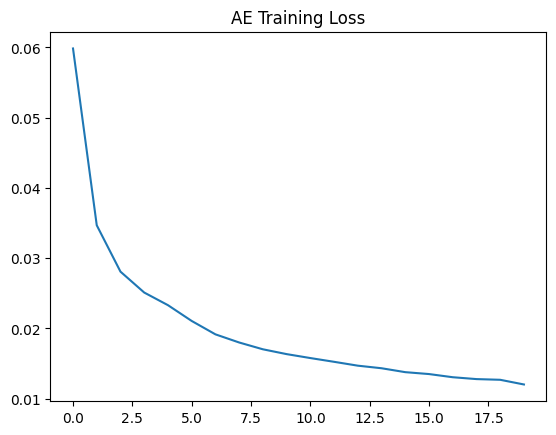

In [33]:
plt.plot(history)
plt.title("AE Training Loss")
plt.savefig("../results/ae_trainloss.png", dpi=300)
plt.show()

### Застосування автоенкодера

денойзинг

In [42]:
# 1 batch
model.eval()
x_batch, _ = next(iter(train_loader))
x_batch = x_batch.to(device)

with torch.no_grad():
    x_noisy = add_noise(x_batch)
    x_denoised = model(x_noisy)

x_batch = x_batch.cpu()
x_noisy = x_noisy.cpu()
x_denoised = x_denoised.cpu()

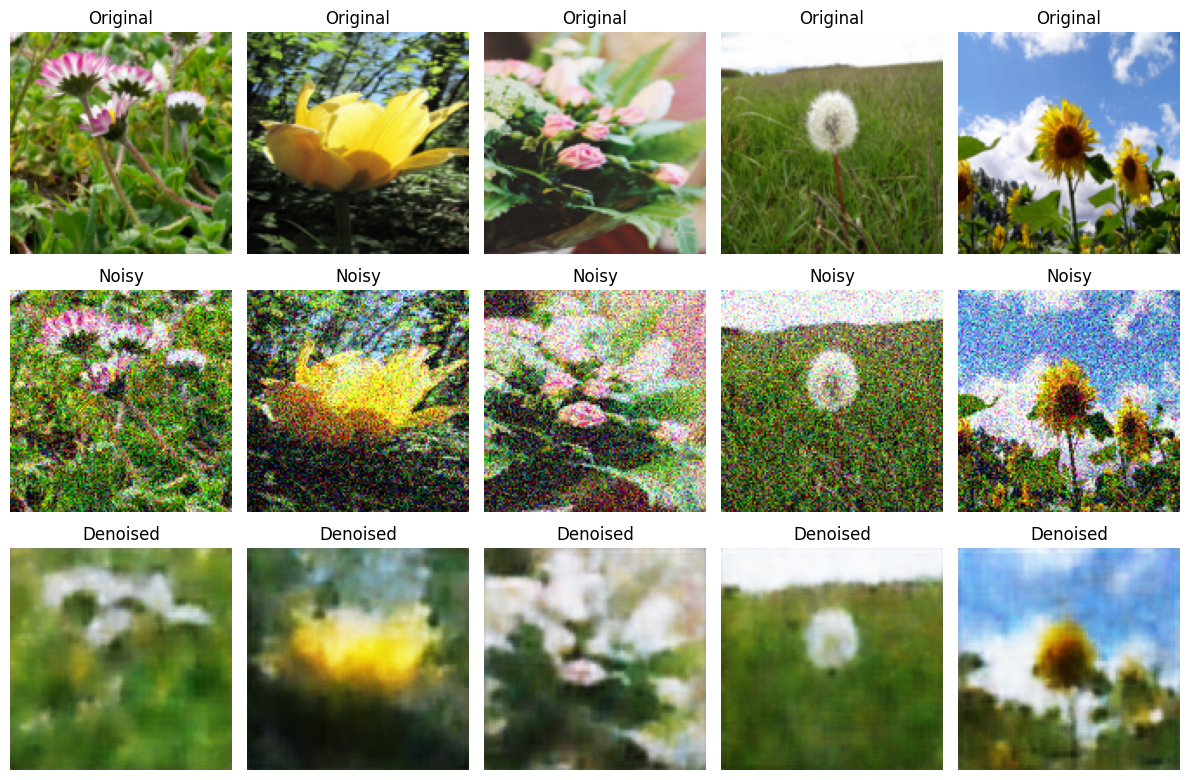

In [43]:
plt.figure(figsize=(12, 8))

for i in range(5):
    # og
    plt.subplot(3,5,i+1)
    plt.imshow(x_batch[i].permute(1,2,0))
    plt.title("Original")
    plt.axis("off")

    # noised
    plt.subplot(3,5,5+i+1)
    plt.imshow(x_noisy[i].permute(1,2,0))
    plt.title("Noisy")
    plt.axis("off")

    # denoised
    plt.subplot(3,5,10+i+1)
    plt.imshow(x_denoised[i].permute(1,2,0))
    plt.title("Denoised")
    plt.axis("off")

plt.tight_layout()
plt.savefig("../results/ae_denoiz_noiz.png", dpi=300)
plt.show()

детектор аномалій

In [68]:
# anomaly detection
test_ds = FlowersDataset("../data/processed/test", transform=get_ae_transforms())
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

errors = []
images_list = []

model.eval()
with torch.no_grad():
    for x, _ in test_loader:
        x = x.to(device)

        x_noisy = add_noise(x)
        x_denoised = model(x_noisy)

        pixel_loss = F.mse_loss(x_denoised, x, reduction='none')
        sample_loss = pixel_loss.mean(dim=[1, 2, 3])

        errors.extend(sample_loss.cpu().numpy())
        images_list.extend(x.cpu())


errors = np.array(errors)
idx = np.argsort(errors)[-5:]


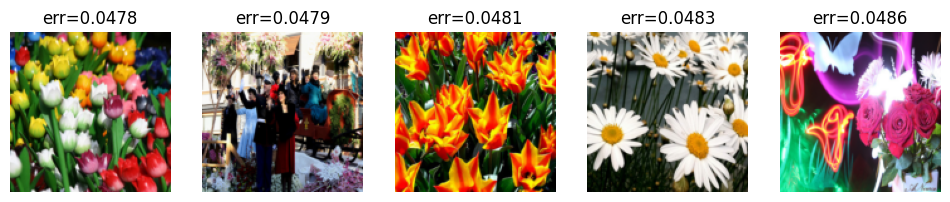

Min error: 0.0024383294
Max error: 0.048554372
Mean error: 0.018751262
Std error: 0.009173222


In [69]:
plt.figure(figsize=(12,6))
for i, index in enumerate(idx):
    plt.subplot(1,5,i+1)
    img = images_list[index].permute(1,2,0)
    plt.imshow(img)
    plt.title(f"err={errors[index]:.4f}")
    plt.axis("off")
plt.savefig("../results/ae_denoiz_anomalies_test_on_noized.png", dpi=300)
plt.show()

print("Min error:", errors.min())
print("Max error:", errors.max())
print("Mean error:", errors.mean())
print("Std error:", errors.std())